In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = F.log_softmax(out, dim=-1)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

class Loader(object):
  def __init__(self, data_mean, data_std_dev):
    super(Loader, self).__init__()
    
    self.cuda = torch.cuda.is_available()
    self.device = torch.device("cuda" if self.cuda else "cpu")

    self.model = ResNet18().to(self.device)

    transform = transforms.Compose(
    [transforms.RandomRotation(15),
     transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(data_mean, data_std_dev)])
    
    test_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(data_mean, data_std_dev)])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    
    self.trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                              shuffle=True, num_workers=4, pin_memory=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=test_transforms)
    self.testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                            shuffle=False, num_workers=4, pin_memory=True)

    self.classes = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  def disp_image(self, trainloader):
    def imshow(img):
      img = img / 2 + 0.5     # unnormalize
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))


    # get some random training images
    dataiter = iter(self.trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % self.classes[labels[j]] for j in range(4)))

  def print_sum(self):
    summary(self.model, input_size=(3, 32, 32))

  def train(self, limit, learning_rate=0.01, momentum=0.9):
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(limit):
        self.model.train()
        pbar = tqdm(self.trainloader)
        correct = 0
        processed = 0

        print("EPOCH:", epoch)

        for batch_idx, (data, labels) in enumerate(pbar):
            data, labels = data.to(self.device), labels.to(self.device)

            # Init
            optimizer.zero_grad()
            # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
            # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

            # Predict
            y_pred = self.model(data)

            # Calculate loss
            loss = F.nll_loss(y_pred, labels)
            self.train_losses.append(loss)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Update pbar-tqdm
            pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
            processed += len(data)

            pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
            self.train_acc.append(100*correct/processed)
        self.test()
      

  def test(self):
      self.model.eval()
      test_loss = 0
      correct = 0
      pbar = tqdm(self.testloader)
      with torch.no_grad():
          for batch_idx, (data, labels) in enumerate(pbar):
              data, labels = data.to(self.device), labels.to(self.device)
              output = self.model(data)
              test_loss += F.nll_loss(output, labels, reduction='sum').item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              correct += pred.eq(labels.view_as(pred)).sum().item()

      test_loss /= len(self.testloader.dataset)
      self.test_losses.append(test_loss)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(self.testloader.dataset),
          100. * correct / len(self.testloader.dataset)))
      
      self.test_acc.append(100. * correct / len(self.testloader.dataset))
    
  def class_accuracy(self):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in self.testloader:
            images, labels = data
            images, labels = images.to(self.device), labels.to(self.device)

            outputs = self.model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            self.classes[i], 100 * class_correct[i] / class_total[i]))

In [2]:
data_mean = (0.4914, 0.4822, 0.4465)
data_std_dev = (0.2470, 0.2435, 0.2616)

cifar = Loader(data_mean, data_std_dev)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse plane   dog plane


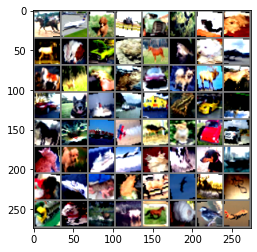

In [3]:
cifar.disp_image(cifar.trainloader)

In [4]:
cifar.print_sum()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [5]:
learning_rate = 0.01
momentum = 0.9
epoch = 20

cifar.train(epoch, learning_rate, learning_rate)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.109291672706604 Batch_id=781 Accuracy=45.43: 100%|██████████| 782/782 [01:48<00:00,  7.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3872, Accuracy: 4960/10000 (49.60%)

EPOCH: 1


Loss=0.9754535555839539 Batch_id=781 Accuracy=60.28: 100%|██████████| 782/782 [01:48<00:00,  7.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3193, Accuracy: 5600/10000 (56.00%)

EPOCH: 2


Loss=1.0393790006637573 Batch_id=781 Accuracy=67.86: 100%|██████████| 782/782 [01:48<00:00,  7.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0866, Accuracy: 6358/10000 (63.58%)

EPOCH: 3


Loss=0.8641433715820312 Batch_id=781 Accuracy=72.31: 100%|██████████| 782/782 [01:48<00:00,  7.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8719, Accuracy: 7023/10000 (70.23%)

EPOCH: 4


Loss=0.8188267350196838 Batch_id=781 Accuracy=75.51: 100%|██████████| 782/782 [01:48<00:00,  7.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2086, Accuracy: 6451/10000 (64.51%)

EPOCH: 5


Loss=1.2549501657485962 Batch_id=781 Accuracy=77.52: 100%|██████████| 782/782 [01:48<00:00,  7.22it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9528, Accuracy: 7099/10000 (70.99%)

EPOCH: 6


Loss=1.2037365436553955 Batch_id=781 Accuracy=79.43: 100%|██████████| 782/782 [01:48<00:00,  7.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6691, Accuracy: 7665/10000 (76.65%)

EPOCH: 7


Loss=0.6410271525382996 Batch_id=781 Accuracy=80.82: 100%|██████████| 782/782 [01:48<00:00,  7.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9050, Accuracy: 7158/10000 (71.58%)

EPOCH: 8


Loss=0.8544554114341736 Batch_id=781 Accuracy=81.96: 100%|██████████| 782/782 [01:48<00:00,  7.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6241, Accuracy: 7876/10000 (78.76%)

EPOCH: 9


Loss=0.4031609892845154 Batch_id=781 Accuracy=83.08: 100%|██████████| 782/782 [01:48<00:00,  7.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6195, Accuracy: 7983/10000 (79.83%)

EPOCH: 10


Loss=0.456083744764328 Batch_id=781 Accuracy=84.09: 100%|██████████| 782/782 [01:48<00:00,  7.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5799, Accuracy: 8087/10000 (80.87%)

EPOCH: 11


Loss=0.5690895318984985 Batch_id=781 Accuracy=84.83: 100%|██████████| 782/782 [01:48<00:00,  7.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6121, Accuracy: 8006/10000 (80.06%)

EPOCH: 12


Loss=0.40503254532814026 Batch_id=781 Accuracy=85.54: 100%|██████████| 782/782 [01:48<00:00,  7.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5777, Accuracy: 8122/10000 (81.22%)

EPOCH: 13


Loss=0.6126740574836731 Batch_id=781 Accuracy=86.28: 100%|██████████| 782/782 [01:48<00:00,  7.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5510, Accuracy: 8242/10000 (82.42%)

EPOCH: 14


Loss=0.5951498746871948 Batch_id=781 Accuracy=86.95: 100%|██████████| 782/782 [01:48<00:00,  7.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5051, Accuracy: 8336/10000 (83.36%)

EPOCH: 15


Loss=0.3879547715187073 Batch_id=781 Accuracy=87.59: 100%|██████████| 782/782 [01:48<00:00,  7.21it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5004, Accuracy: 8375/10000 (83.75%)

EPOCH: 16


Loss=0.5793956518173218 Batch_id=781 Accuracy=88.01: 100%|██████████| 782/782 [01:48<00:00,  7.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5407, Accuracy: 8272/10000 (82.72%)

EPOCH: 17


Loss=0.8383899331092834 Batch_id=781 Accuracy=88.43: 100%|██████████| 782/782 [01:48<00:00,  7.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6737, Accuracy: 7911/10000 (79.11%)

EPOCH: 18


Loss=0.3550097644329071 Batch_id=781 Accuracy=88.98: 100%|██████████| 782/782 [01:48<00:00,  7.19it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4858, Accuracy: 8455/10000 (84.55%)

EPOCH: 19


Loss=0.17947453260421753 Batch_id=781 Accuracy=89.55: 100%|██████████| 782/782 [01:48<00:00,  7.20it/s]
100%|██████████| 157/157 [00:06<00:00, 22.96it/s]


Test set: Average loss: 0.4415, Accuracy: 8555/10000 (85.55%)

